# Import des modules

In [205]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
import shap

#Modèles
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

#Metriques
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score, roc_curve, auc, ConfusionMatrixDisplay

# Undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


In [206]:
fc = pd.read_csv('fc_after_feature_engineering.csv')
print(fc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 51 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   a_quitte_l_entreprise                      1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   annees_dans_l_entreprise                   1470 non-null   int64  
 3   annees_dans_le_poste_actuel                1470 non-null   int64  
 4   annees_depuis_la_derniere_promotion        1470 non-null   int64  
 5   annees_experience_totale                   1470 non-null   int64  
 6   annes_sous_responsable_actuel              1470 non-null   int64  
 7   augmentation_salaire_precedente            1470 non-null   int64  
 8   departement_Commercial                     1470 non-null   int64  
 9   departement_Consulting                     1470 non-null   int64  
 10  departement_Ressources H

# Déclaration des Dataframes X et y
- Un DataFrame contenant les features => X
- Un Pandas Series contenant la colonne cible => y

In [207]:
# hommes ou femmes = genre
# célibataires = statut_marital
# Jeunes = age
# Faible Revenus = revenu_mensuel
# poste de consultant ou cadre commercial = poste
# moins satisfaits = satisfaction_globale
#  = score_mobilite_externe
#  = score_mobilite_interne
#  = nombre_experiences_precedentes
# score_equilibre_pro_perso = heures supplémentaires + déplacement professionnels fréquents +  distance domicile/travail plus élevée
# heures supplémentaires
# déplacement professionnels fréquents
# distance domicile/travail plus élevée

# Test 1
#columns_base = ['heure_supplementaires','genre','revenu_mensuel', 'age', 'distance_domicile_travail', 'augmentation_salaire_precedente','frequence_deplacement', 'nb_formations_suivies', 'niveau_education', 'niveau_hierarchique_poste', 'nombre_experiences_precedentes', 'nombre_participation_pee', 'note_evaluation_precedente']

# Test 2
#columns_base = ['genre', 'age', 'revenu_mensuel', 'satisfaction_globale', 'score_mobilite_externe', 'score_mobilite_interne', 'nombre_experiences_precedentes', 'score_equilibre_pro_perso']

# Test 3
# columns_base = ['genre', 'age', 'revenu_mensuel', 'satisfaction_globale', 'score_mobilite_externe', 'score_mobilite_interne', 'nombre_experiences_precedentes', 'heure_supplementaires' ,'frequence_deplacement', 'distance_domicile_travail']

# FINAL
columns_base = ['heure_supplementaires', 'age', 'distance_domicile_travail', 'frequence_deplacement', 'nb_formations_suivies', 'nombre_participation_pee', 'note_evaluation_precedente', 'satisfaction_globale', 'annees_dans_l_entreprise', 'annees_depuis_la_derniere_promotion', 'score_mobilite_externe', 'score_mobilite_interne', 'statut_marital_Divorce(e)' ]

columns_annees = [col for col in fc.columns if col.startswith('annees')]
columns_domaine_etude = [col for col in fc.columns if col.startswith('domaine_etude')]
columns_poste = [col for col in fc.columns if col.startswith('poste')]
columns_statut_marital = [col for col in fc.columns if col.startswith('statut_marital')]
columns_satisfaction = [col for col in fc.columns if col.startswith('satisfaction')]

# Test 1
#all_columns = columns_base + columns_statut_marital + columns_domaine_etude + columns_poste + columns_satisfaction + columns_annees

# Test 2 + Test 3
# all_columns = columns_base + columns_statut_marital + columns_poste

# FINAL
all_columns = columns_base  + columns_poste

X = fc[all_columns]
y = fc['a_quitte_l_entreprise']

# Split train/test
- test_size = 15%
- stratify=y

In [222]:
random_state = 82
test_size = 0.15

# Le terme stratification désigne une méthode d’échantillonnage qui garantit que la répartition des classes reste proportionnelle entre les jeux d’entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Taux de classe 1 dans y_train et y_test
taux_classe1_train = (y_train == 1).mean() * 100
taux_classe1_test  = (y_test == 1).mean() * 100

print(f"Taux de classe 1 dans y_train : {taux_classe1_train:.2f}%")
print(f"Taux de classe 1 dans y_test  : {taux_classe1_test:.2f}%")

Taux de classe 1 dans y_train : 16.09%
Taux de classe 1 dans y_test  : 16.29%


# Entrainement Modele Classification


In [209]:
def train_model(model, X_train, X_test, y_train, y_test, model_name, overfit_threshold=0.12, use_sampling=False, use_weights=True):
    """
    Entraîne un modèle et retourne les métriques train/test avec détection d'overfitting.

    Args:
        model: Le modèle à entraîner
        X_train, X_test: Features d'entraînement et de test
        y_train, y_test: Labels d'entraînement et de test
        model_name: Nom du modèle (string)

    Returns:
        tuple: (results, report_test, cm, curves, pipeline)
    """

    # Undersampling AVANT la création du pipeline
    if use_sampling:
        tt_pipeline = ImbPipeline(steps=[
            ('scaler', StandardScaler()),      # Standardiser D'ABORD
            ('over', SMOTE(sampling_strategy=0.1, random_state=random_state)),
            ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=random_state)),
            ('model', model)
        ])
        tt_pipeline.fit(X_train, y_train)

    # Entraînement avec les poids
    if use_weights:
        tt_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('model', model)
        ])
        weights = compute_sample_weight(class_weight='balanced', y=y_train)
        tt_pipeline.fit(X_train, y_train, model__sample_weight=weights)


    # Prédictions sur TRAIN
    y_pred_train = tt_pipeline.predict(X_train)
    class_report_train = classification_report(y_train, y_pred_train, output_dict=True, zero_division=0)

    # Prédictions sur TEST
    y_pred_test = tt_pipeline.predict(X_test)
    class_report_test = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_test)

    # Définir les labels des classes
    class_labels = ['En Poste', 'Demission']  # Modifiez selon vos classes

    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Calcul des écarts (train - test) pour détecter l'overfitting
    accuracy_gap = class_report_train['accuracy'] - class_report_test['accuracy']
    f1_gap = class_report_train['macro avg']['f1-score'] - class_report_test['macro avg']['f1-score']

    # Indicateur d'overfitting
    overfitting_flag = 'OUI' if (accuracy_gap >= overfit_threshold or f1_gap >= overfit_threshold) else 'NON'

    # Extraction des métriques principales
    tt_results = {
        'model': model_name,
        'method': 'train_test',
        # Métriques TRAIN
        'train_accuracy': round(class_report_train['accuracy'], 2),
        'train_f1_macro': round(class_report_train['macro avg']['f1-score'], 2),
        'train_precision_macro': round(class_report_train['macro avg']['precision'], 2),
        'train_recall_macro': round(class_report_train['macro avg']['recall'], 2),
        # Métriques TEST
        'test_accuracy': round(class_report_test['accuracy'], 2),
        'test_f1_macro': round(class_report_test['macro avg']['f1-score'], 2),
        'test_precision_macro': round(class_report_test['macro avg']['precision'], 2),
        'test_recall_macro': round(class_report_test['macro avg']['recall'], 2),
        # Écarts et overfitting
        'accuracy_gap': round(accuracy_gap, 2),
        'f1_gap': round(f1_gap, 2),
        'overfitting': overfitting_flag,
        'confusion_matrix': str(tt_cm.tolist()),
    }

    print(">>>>>> Train Test <<<<<<")
    print(f"> accuracy        : {tt_results['test_accuracy']:.2f}")
    print(f"> f1              : {tt_results['test_f1_macro']:.2f}")
    print(f"> precision       : {tt_results['test_precision_macro']:.2f}")
    print(f"> recall          : {tt_results['test_recall_macro']:.2f}")
    print(f"> accuracy_gap    : {tt_results['accuracy_gap']:.2f}")
    print(f"> f1_gap          : {tt_results['f1_gap']:.2f}")
    print(f"> confusion_matrix: {tt_results['confusion_matrix']}")

    # Récupérer le modèle entraîné du pipeline
    trained_model = tt_pipeline.named_steps['model']
    X_test_scaled = tt_pipeline.named_steps['scaler'].transform(X_test)
    y_true = y_test.copy() if hasattr(y_test, 'copy') else list(y_test)

    # Vérifier si le modèle supporte predict_proba
    try:
        y_pred_proba = trained_model.predict_proba(X_test_scaled)
        y_score = y_pred_proba[:, 1]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        print(f"> AUC ROC       : {roc_auc:.2f}")

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        avg_precision = average_precision_score(y_true, y_score)
        print(f"> AUC PRC       : {avg_precision:.2f}")

    except AttributeError:
        y_pred_proba = None

    # Données pour les courbes ROC et PR
    tt_curves = {
        'model': model_name,
        'y_true': y_true,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred_test
    }

    return tt_results, class_report_test, cm, tt_curves, tt_pipeline

### <font color="orange">Validation Croisée</font>
- StratifiedKFold

In [210]:
def cross_validation_evaluation(model, X, y, cv=5, overfit_threshold=0.12):
    """
    Effectue une validation croisée et retourne les métriques avec détection d'overfitting.

    Args:
        model: Le modèle à évaluer
        X: Features complètes
        y: Labels complets
        cv: Nombre de folds (défaut: 5)

    Returns:
        dict: Dictionnaire contenant les résultats moyens avec scores train et test
    """

    # Création du pipeline avec scaling
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
    ])

    # Définition des métriques à calculer
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    # Validation croisée avec return_train_score=True pour détecter overfitting
    # Par défaut, cross_validate utilisera KFold, qui ne conserve pas la proportion de classes.
    # results_cross_validate = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True, error_score='raise')

    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    results_cross_validate = cross_validate(
        pipeline, X, y, cv=cv_strategy, scoring=scoring,
        return_train_score=True, error_score='raise'
    )

    # Calcul des écarts moyens (train - test)
    accuracy_gap_cv = results_cross_validate['train_accuracy'].mean() - results_cross_validate['test_accuracy'].mean()
    f1_gap_cv = results_cross_validate['train_f1_macro'].mean() - results_cross_validate['test_f1_macro'].mean()

    # Indicateur d'overfitting
    overfitting_flag_cv = 'OUI' if (accuracy_gap_cv >= overfit_threshold or f1_gap_cv >= overfit_threshold) else 'NON'

    # Calcul des moyennes et écarts-types
    cv_results = {
        'model': type(model).__name__,
        'method': 'cross_validation',
        # Métriques TRAIN
        'train_accuracy': round(results_cross_validate['train_accuracy'].mean(), 2),
        'train_accuracy_std': round(results_cross_validate['train_accuracy'].std(), 2),
        'train_f1_macro': round(results_cross_validate['train_f1_macro'].mean(), 2),
        'train_f1_macro_std': round(results_cross_validate['train_f1_macro'].std(), 2),
        'train_precision_macro': round(results_cross_validate['train_precision_macro'].mean(), 2),
        'train_recall_macro': round(results_cross_validate['train_recall_macro'].mean(), 2),
        # Métriques TEST
        'test_accuracy': round(results_cross_validate['test_accuracy'].mean(), 2),
        'test_accuracy_std': round(results_cross_validate['test_accuracy'].std(), 2),
        'test_f1_macro': round(results_cross_validate['test_f1_macro'].mean(), 2),
        'test_f1_macro_std': round(results_cross_validate['test_f1_macro'].std(), 2),
        'test_precision_macro': round(results_cross_validate['test_precision_macro'].mean(), 2),
        'test_recall_macro': round(results_cross_validate['test_recall_macro'].mean(), 2),
        # Écarts et overfitting
        'accuracy_gap': round(accuracy_gap_cv, 2),
        'f1_gap': round(f1_gap_cv, 2),
        'overfitting': overfitting_flag_cv,
        'confusion_matrix': 'N/A',
    }

    print(">>>>>> Cross Validate <<<<<<")
    print(f"> accuracy        : {cv_results['test_accuracy']:.2f}")
    print(f"> f1              : {cv_results['test_f1_macro']:.2f}")
    print(f"> precision       : {cv_results['test_precision_macro']:.2f}")
    print(f"> recall          : {cv_results['test_recall_macro']:.2f}")
    print(f"> accuracy_gap    : {cv_results['accuracy_gap']:.2f}")
    print(f"> f1_gap          : {cv_results['f1_gap']:.2f}")

    return cv_results

### <font color="orange">Permutation Importance</font>

In [211]:
def compute_permutation_importance(pipeline, X_test, y_test, n_repeats=10):
    """
    Calcule la permutation importance pour un modèle entraîné.
    Args:
        pipeline: Pipeline entraîné contenant scaler et modèle
        X_test: Features de test
        y_test: Labels de test
        n_repeats: Nombre de répétitions pour la permutation (défaut: 10)

    Returns:
        pd.DataFrame: DataFrame avec les importances par feature
    """
    trained_model = pipeline.named_steps['model']
    X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)

    # Permutation importance sur les données scalées
    pi = permutation_importance(
        trained_model,
        X_test_scaled,
        y_test,
        n_repeats=n_repeats,
        random_state=random_state
    )

    # Construction du DataFrame d'importances
    df_compute_perm_imp = pd.DataFrame({
        'model': type(trained_model).__name__,
        'feature': X_test.columns,
        'importance_mean': pi.importances_mean,
        'importance_std': pi.importances_std
    })

    # Ajouter les feature importances natives si disponibles
    if hasattr(trained_model, 'feature_importances_'):
        df_compute_perm_imp['feature_importances'] = trained_model.feature_importances_

    return df_compute_perm_imp

### <font color="orange">SHAP VALUES</font>
- Beeswarm Plot
- TreeExplainer

In [212]:
def compute_shap_values(pipeline, X_test):
    """
    Calcule les valeurs SHAP pour un modèle tree-based.
    Args:
        pipeline: Pipeline entraîné contenant scaler et modèle
        X_test: Features de test
    Returns:
        dict: Dictionnaire contenant les valeurs SHAP et métadonnées
              ou None si le modèle n'est pas compatible
    """
    trained_model = pipeline.named_steps['model']
    X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)

    # SHAP uniquement pour modèles tree-based
    tree_based_models = (XGBClassifier, CatBoostClassifier)

    if not isinstance(trained_model, tree_based_models):
        print(f"⚠ Modèle ignoré (non compatible avec TreeExplainer): {type(trained_model).__name__}")
        return None

    # Calcul des valeurs SHAP
    explainer = shap.TreeExplainer(trained_model)
    shap_values = explainer.shap_values(X_test_scaled)

    # Récupérer les noms de features
    feature_names_in = (
        trained_model.feature_names_in_
        if hasattr(trained_model, 'feature_names_in_')
        else X_test.columns.tolist()
    )

    # Créer un DataFrame avec les bonnes colonnes pour le plot
    X_test_scaled_df = pd.DataFrame(
        X_test_scaled,
        columns=feature_names_in,
        index=X_test.index
    )

    # Métadonnées SHAP
    shap_metadata = {
        'model': type(trained_model).__name__,
        'shap_values': shap_values,
        'X_test_scaled': X_test_scaled_df,  # DataFrame avec noms de colonnes
        'feature_names': feature_names_in,
        'explainer': explainer
    }

    return shap_metadata

### <font color="orange">SHAP VALUES</font>
- Waterfall Plot
- Feature Importance locale
- Explainer

In [213]:
def compute_shap_values_local(model, X_test, y_pred):

    # Pour la feature importance locale, utilisez le Waterfall Plot
    # SHAP uniquement pour modèles tree-based
    tree_based_models = (XGBClassifier, CatBoostClassifier)

    if not isinstance(model, tree_based_models):
        print(f"⚠ Modèle ignoré (non compatible avec TreeExplainer): {type(model).__name__}")
        return None

    # Calcul des valeurs SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    idx_class_0a = np.where(y_pred == 0)[0][0]  # 1er échantillon de classe 0
    idx_class_0b = np.where(y_pred == 0)[0][1]  # 2eme échantillon de classe 0
    idx_class_1a = np.where(y_pred == 1)[0][0]  # 1er échantillon de classe 1
    idx_class_1b = np.where(y_pred == 1)[0][1]  # 2eme échantillon de classe 1

    print(f"Echantillon 1 classe 0: {idx_class_0a}")
    print(f"Echantillon 2 classe 0: {idx_class_0b}")
    print(f"Echantillon 1 classe 1: {idx_class_1a}")
    print(f"Echantillon 2 classe 1: {idx_class_1b}")

    model_name = type(model).__name__

    # Créer une figure avec 2x2 subplots - taille augmentée
    fig = plt.figure(figsize=(24, 20))

    # Classe 0 - échantillon A
    ax1 = plt.subplot(2, 2, 1)
    shap.plots.waterfall(shap_values[idx_class_0a], show=False, max_display=15)
    plt.title(f'Classe 0 - Échantillon A (idx={idx_class_0a})', fontsize=12, pad=15)
    for text in ax1.texts:
        text.set_fontsize(8)
    ax1.tick_params(axis='both', labelsize=8)

    # Classe 0 - échantillon B
    ax2 = plt.subplot(2, 2, 2)
    shap.plots.waterfall(shap_values[idx_class_0b], show=False, max_display=15)
    plt.title(f'Classe 0 - Échantillon B (idx={idx_class_0b})', fontsize=12, pad=15)
    for text in ax2.texts:
        text.set_fontsize(8)
    ax2.tick_params(axis='both', labelsize=8)

    # Classe 1 - échantillon A
    ax3 = plt.subplot(2, 2, 3)
    shap.plots.waterfall(shap_values[idx_class_1a], show=False, max_display=15)
    plt.title(f'Classe 1 - Échantillon A (idx={idx_class_1a})', fontsize=12, pad=15)
    for text in ax3.texts:
        text.set_fontsize(8)
    ax3.tick_params(axis='both', labelsize=8)

    # Classe 1 - échantillon B
    ax4 = plt.subplot(2, 2, 4)
    shap.plots.waterfall(shap_values[idx_class_1b], show=False, max_display=15)
    plt.title(f'Classe 1 - Échantillon B (idx={idx_class_1b})', fontsize=12, pad=15)
    for text in ax4.texts:
        text.set_fontsize(8)
    ax4.tick_params(axis='both', labelsize=8)

    plt.suptitle(f'SHAP Waterfall Plots - {model_name}', fontsize=12, y=0.998)
    plt.tight_layout()
    plt.savefig(f"images/classification_waterfall_plot_{model_name}_combined.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # Enregistrement individuel (inchangé)
    shap.plots.waterfall(shap_values[idx_class_0a], show=False)
    plt.savefig(f"images/classification_waterfall_plot_{model_name}_class0a.png", bbox_inches='tight', dpi=300)
    plt.close()
    shap.plots.waterfall(shap_values[idx_class_0b], show=False)
    plt.savefig(f"images/classification_waterfall_plot_{model_name}_class0b.png", bbox_inches='tight', dpi=300)
    plt.close()
    shap.plots.waterfall(shap_values[idx_class_1a], show=False)
    plt.savefig(f"images/classification_waterfall_plot_{model_name}_class1a.png", bbox_inches='tight', dpi=300)
    plt.close()
    shap.plots.waterfall(shap_values[idx_class_1b], show=False)
    plt.savefig(f"images/classification_waterfall_plot_{model_name}_class1b.png", bbox_inches='tight', dpi=300)
    plt.close()

## Split et Entrainement Modeles Classification

- DummyClassifier
- LogisticRegression
- XGBClassifier
- CatBoostClassifier

#################################
##### DummyClassifier
#################################
50.23%


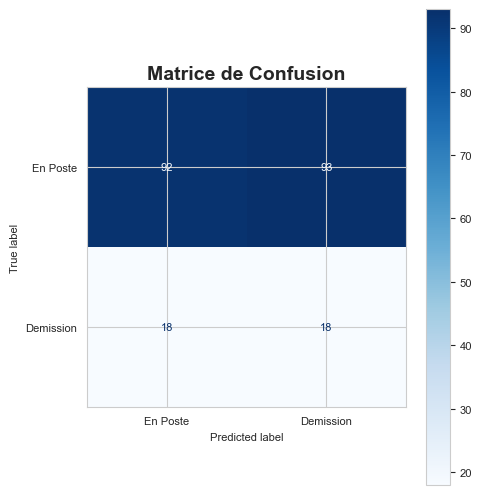

>>>>>> Train Test <<<<<<
> accuracy        : 0.50
> f1              : 0.43
> precision       : 0.50
> recall          : 0.50
> accuracy_gap    : -0.00
> f1_gap          : -0.00
> confusion_matrix: [[167, 18], [14, 22]]
> AUC ROC       : 0.50
> AUC PRC       : 0.16
>>>>>> Cross Validate <<<<<<
> accuracy        : 0.71
> f1              : 0.48
> precision       : 0.49
> recall          : 0.48
> accuracy_gap    : 0.03
> f1_gap          : 0.02
⚠ Modèle ignoré (non compatible avec TreeExplainer): DummyClassifier
⚠ Modèle ignoré (non compatible avec TreeExplainer): DummyClassifier
#################################
##### LogisticRegression
#################################
35.75%


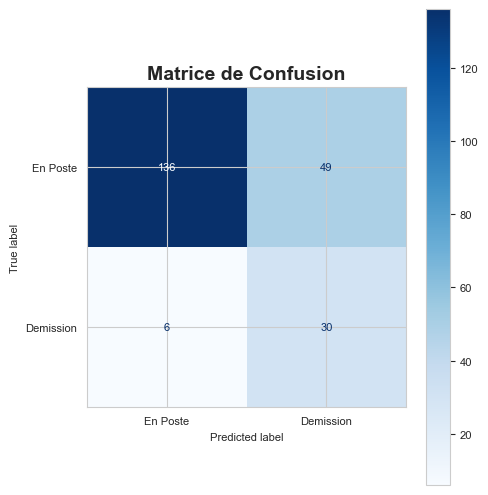

>>>>>> Train Test <<<<<<
> accuracy        : 0.75
> f1              : 0.68
> precision       : 0.67
> recall          : 0.78
> accuracy_gap    : 0.01
> f1_gap          : 0.00
> confusion_matrix: [[92, 93], [18, 18]]
> AUC ROC       : 0.85
> AUC PRC       : 0.64
>>>>>> Cross Validate <<<<<<
> accuracy        : 0.88
> f1              : 0.72
> precision       : 0.81
> recall          : 0.68
> accuracy_gap    : 0.01
> f1_gap          : 0.01
⚠ Modèle ignoré (non compatible avec TreeExplainer): LogisticRegression
⚠ Modèle ignoré (non compatible avec TreeExplainer): LogisticRegression
#################################
##### XGBClassifier
#################################
28.05%


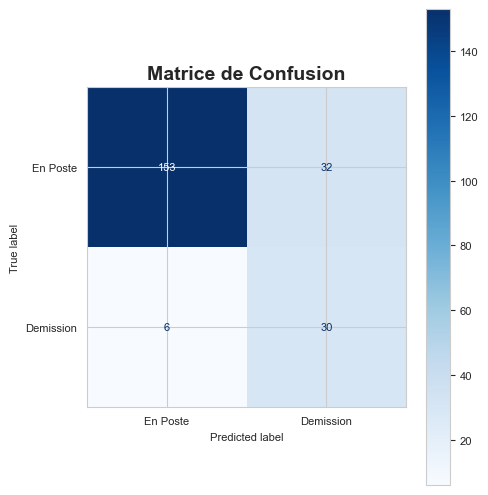

>>>>>> Train Test <<<<<<
> accuracy        : 0.83
> f1              : 0.75
> precision       : 0.72
> recall          : 0.83
> accuracy_gap    : 0.09
> f1_gap          : 0.13
> confusion_matrix: [[136, 49], [6, 30]]
> AUC ROC       : 0.88
> AUC PRC       : 0.58
>>>>>> Cross Validate <<<<<<
> accuracy        : 0.84
> f1              : 0.72
> precision       : 0.71
> recall          : 0.72
> accuracy_gap    : 0.14
> f1_gap          : 0.25
Echantillon 1 classe 0: 0
Echantillon 2 classe 0: 1
Echantillon 1 classe 1: 5
Echantillon 2 classe 1: 8


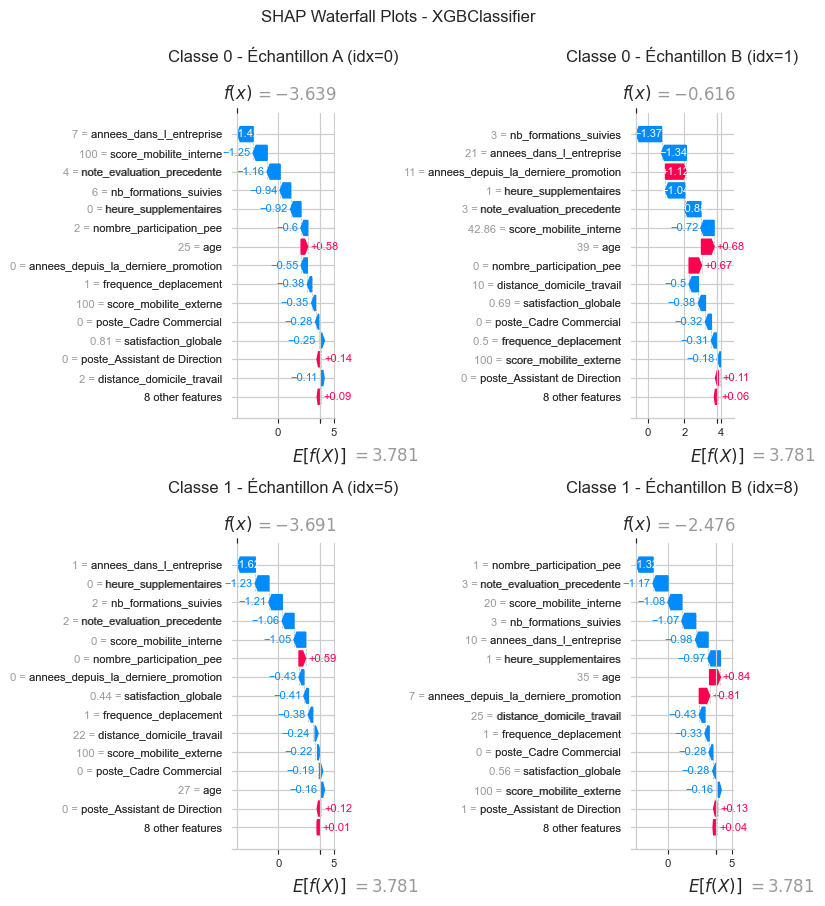

#################################
##### CatBoostClassifier
#################################
18.10%


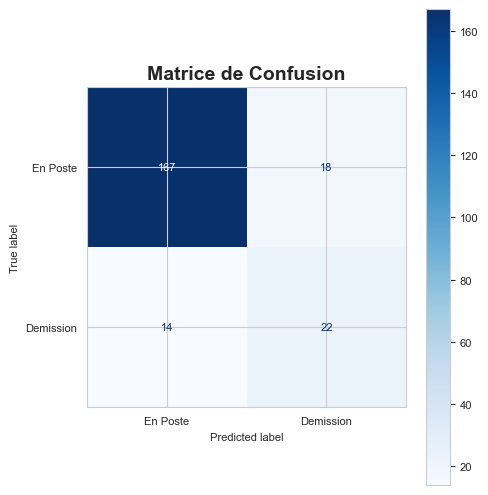

>>>>>> Train Test <<<<<<
> accuracy        : 0.86
> f1              : 0.75
> precision       : 0.74
> recall          : 0.76
> accuracy_gap    : 0.11
> f1_gap          : 0.19
> confusion_matrix: [[153, 32], [6, 30]]
> AUC ROC       : 0.85
> AUC PRC       : 0.64
>>>>>> Cross Validate <<<<<<
> accuracy        : 0.87
> f1              : 0.68
> precision       : 0.80
> recall          : 0.64
> accuracy_gap    : 0.09
> f1_gap          : 0.24
Echantillon 1 classe 0: 0
Echantillon 2 classe 0: 1
Echantillon 1 classe 1: 4
Echantillon 2 classe 1: 5


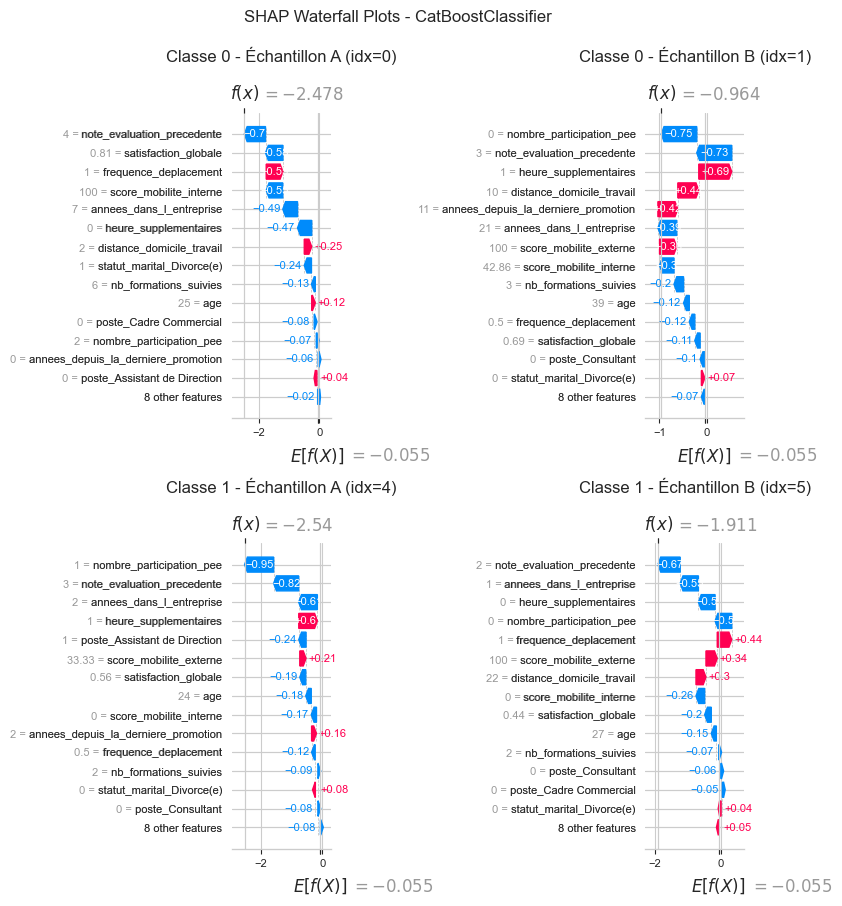

In [214]:
# Définition des modèles
models = {
    'DummyClassifier': DummyClassifier(
        strategy='stratified',
        random_state=random_state),

    'LogisticRegression': LogisticRegression(
        C=1,
        max_iter=5000,
        penalty='l1',
        solver='liblinear',
        random_state=random_state),

    'XGBClassifier': XGBClassifier(
        n_estimators=200,       # Nombre d’arbres construits par le modèle.
        max_depth=3,            # Profondeur maximale de chaque arbre.
        learning_rate=0.3,      # Taux d’apprentissage
        subsample=0.8,          # 80% des données par arbre
        reg_lambda=5,           # Régularisation L2 (pénalité sur les poids trop grands).
        reg_alpha=0.1,
        eval_metric='logloss',  # Fonction de perte utilisée pour mesurer l’erreur pendant l’entraînement.
        scale_pos_weight=5,     # Permet de compenser un déséquilibre entre les classes.
        random_state=random_state),

    'CatBoostClassifier': CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        l2_leaf_reg=3,        # Régularisation
        subsample=0.8,
        verbose=False,
        random_state=random_state)
}

results_prov = []
results_global = []
class_report = []
all_curves = []
all_compute_perm_imp = []
all_shap_metadata = []
all_importances_metadata = []
waterfall_data = []

for model_name, model in models.items():
    print(f"#################################")
    print(f"##### {model_name}")
    print(f"#################################")

    # Entraînement
    tt_results, class_report_test, tt_cm, tt_curves, tt_pipeline = train_model(model, X_train, X_test, y_train, y_test, model_name)

    # Cross-validation
    cv_results = cross_validation_evaluation(model, X, y, cv=5)

    # Permutation importance
    compute_perm_imp = compute_permutation_importance(tt_pipeline, X_test, y_test)

    # SHAP
    shap_metadata = compute_shap_values(tt_pipeline, X_test)

    # SHAP Feature Importance Local
    compute_shap_values_local(model, X_test, y_pred=tt_curves['y_pred'])

    # Formater les métadonnées pour garder la compatibilité
    importances_metadata = {
        'model': model_name,
        'X_test': X_test,
        #'X_test_scaled': tt_pipeline.named_steps['scaler'].transform(X_test),
        'feature_names_in': X_test.columns.tolist(),
    }

    class_report.append({
        'model': model_name,
        'method': 'train_test',
        'report': class_report_test,
        'confusion_matrix': tt_cm
    })

    # Sauvegarde des resultats
    results_prov.append(tt_results)
    results_prov.append(cv_results)

    # Conversion en DataFrame
    results_global = pd.DataFrame(results_prov)
    # Réorganisation des colonnes pour la lisibilité
    cols_order = ['model', 'method','train_accuracy', 'test_accuracy', 'accuracy_gap',
                  'train_f1_macro', 'test_f1_macro', 'f1_gap','overfitting',
                  'train_precision_macro', 'test_precision_macro','train_recall_macro', 'test_recall_macro']
    # Ajout des colonnes std si elles existent
    std_cols = [col for col in results_global.columns if '_std' in col]
    cols_order.extend(std_cols)
    cols_order.append('confusion_matrix')
    # Colonnes présentes dans le DataFrame
    cols_order = [col for col in cols_order if col in results_global.columns]
    results_global = results_global[cols_order]

    all_curves.append(tt_curves)
    all_compute_perm_imp.append(compute_perm_imp)
    all_shap_metadata.append(shap_metadata)
    all_importances_metadata.append(importances_metadata)


# Sauvegardes des résultats

In [215]:
# Fichier principal avec toutes les métriques
results_global.to_csv(f'exports/classification_summary.csv', index=False)

# Fichier avec les rapports détaillés de classification
detailed_data = []
for item in class_report:
    model = item['model']
    report = item['report']

    # Extraction des métriques par classe
    for class_label, metrics in report.items():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            detailed_data.append({
                'model': model,
                'class': class_label,
                'precision': round(metrics['precision'], 2),
                'recall': round(metrics['recall'], 2),
                'f1-score': round(metrics['f1-score'], 2),
                'support': metrics['support']
            })

detailed_df = pd.DataFrame(detailed_data)
detailed_df.to_csv(f'exports/classification_by_class.csv', index=False)

# Génération des graphiques

In [216]:
def _plot_binary_roc_curves(all_curves):
    """
    Courbes ROC pour classification binaire.
    """
    plt.figure(figsize=(6, 6))

    for data in all_curves:
        model_name = data['model']
        y_true = data['y_true']

        # Vérifier si les probabilités sont disponibles
        if 'y_pred_proba' in data and data['y_pred_proba'] is not None:
            y_score = data['y_pred_proba']
            # Si format (n_samples, n_classes), prendre la colonne de la classe positive
            if len(y_score.shape) > 1:
                y_score = y_score[:, 1]
        else:
            print(f"⚠️  Pas de probabilités pour {model_name}, utilisation des prédictions")
            y_score = data['y_pred']

        # Calculer la courbe ROC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Ligne diagonale (classificateur aléatoire)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.500)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs', fontsize=12)
    plt.ylabel('Taux de Vrais Positifs', fontsize=12)
    plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    filename = f'images/classification_roc_curves.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [217]:
def _plot_binary_pr_curves(all_curves):
    """
    Courbes Précision-Rappel pour classification binaire.
    """
    plt.figure(figsize=(6, 6))

    for data in all_curves:
        model_name = data['model']
        y_true = data['y_true']

        if 'y_pred_proba' in data and data['y_pred_proba'] is not None:
            y_score = data['y_pred_proba']
            if len(y_score.shape) > 1:
                y_score = y_score[:, 1]
        else:
            print(f"⚠️  Pas de probabilités pour {model_name}, utilisation des prédictions")
            y_score = data['y_pred']

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        avg_precision = average_precision_score(y_true, y_score)

        plt.plot(recall, precision, lw=2,
                 label=f'{model_name} (AP = {avg_precision:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Rappel', fontsize=12)
    plt.ylabel('Précision', fontsize=12)
    plt.title('Courbes Précision-Rappel - Comparaison des Modèles',
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    filename = f'images/classification_precision_recall_curves.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [218]:
def _plot_feature_importance(all_compute_perm_imp):
    """
    Plot de la permutation importance et de la feature importance native pour chaque modèle.
    Affiche les deux graphiques côte à côte (un subplot par modèle).
    """
    # Définir une palette de couleurs pour différencier les modèles
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#FFEAA7']

    # Filtrage des DataFrames valides pour la permutation importance
    df_perm_imp = [df for df in all_compute_perm_imp
                   if not df['importance_mean'].isna().all() and (df['importance_mean'] != 0).any()]

    # Vérifier qu'il reste des DataFrames après le filtrage
    if not df_perm_imp:
        print("Aucun DataFrame valide à tracer.")
        return

    # Créer un graphique pour chaque modèle
    for idx, df in enumerate(df_perm_imp):
        model_name = df['model'].iloc[0]

        # Vérifier si le modèle a des feature_importances natives
        has_native = 'feature_importances' in df.columns and df['feature_importances'].notna().any()

        # Créer la figure avec 1 ou 2 subplots selon la disponibilité des données
        if has_native:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, max(6, len(df) * 0.3)))
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(6, max(6, len(df) * 0.3)))

        # --- Graphique 1: Permutation Importance ---
        df_sorted_perm = df.sort_values('importance_mean', ascending=True)
        ax1.barh(df_sorted_perm['feature'],
                 df_sorted_perm['importance_mean'],
                 color=colors[idx % len(colors)],
                 alpha=0.8)
        ax1.set_xlabel('Importance Mean', fontsize=12)
        ax1.set_ylabel('Features', fontsize=12)
        ax1.set_title(f'Permutation Importance - {model_name}',
                      fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)

        # --- Graphique 2: Native Feature Importance (si disponible) ---
        if has_native:
            df_native = df.copy()
            # Normalisation des importances
            total = df_native['feature_importances'].sum()
            if total != 0:
                df_native['feature_importances'] = df_native['feature_importances'] / total

            df_sorted_native = df_native.sort_values('feature_importances', ascending=True)
            ax2.barh(df_sorted_native['feature'],
                     df_sorted_native['feature_importances'],
                     color=colors[idx % len(colors)],
                     alpha=0.8)
            ax2.set_xlabel('Feature Importance (Normalized)', fontsize=12)
            ax2.set_ylabel('Features', fontsize=12)
            ax2.set_title(f'Native Feature Importance - {model_name}',
                          fontsize=14, fontweight='bold')
            ax2.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Sauvegarder les fichiers individuels
        # Permutation importance
        filename_perm = f'images/classification_permutation_importance_{model_name.replace(" ", "_")}.png'
        fig_perm = plt.figure(figsize=(6, max(6, len(df_sorted_perm) * 0.3)))
        plt.barh(df_sorted_perm['feature'],
                 df_sorted_perm['importance_mean'],
                 color=colors[idx % len(colors)],
                 alpha=0.8)
        plt.xlabel('Importance Mean', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title(f'Permutation Importance - {model_name}',
                  fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(filename_perm, dpi=300, bbox_inches='tight')
        plt.close()

        # Native feature importance (si disponible)
        if has_native:
            filename_native = f'images/classification_native_feature_importance_{model_name.replace(" ", "_")}.png'
            fig_native = plt.figure(figsize=(6, max(6, len(df_sorted_native) * 0.3)))
            plt.barh(df_sorted_native['feature'],
                     df_sorted_native['feature_importances'],
                     color=colors[idx % len(colors)],
                     alpha=0.8)
            plt.xlabel('Feature Importance (Normalized)', fontsize=12)
            plt.ylabel('Features', fontsize=12)
            plt.title(f'Native Feature Importance - {model_name}',
                      fontsize=14, fontweight='bold')
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.savefig(filename_native, dpi=300, bbox_inches='tight')
            plt.close()

In [219]:
def _plot_shap(all_shap_metadata):
    """
    Plot des valeurs SHAP pour les modèles tree-based.

    Args:
        all_shap_metadata: Liste de dictionnaires contenant les métadonnées SHAP
    """
    for meta in all_shap_metadata:
        # Skip si le modèle n'est pas compatible
        if meta is None:
            continue

        model_name = meta['model']
        shap_values = meta['shap_values']
        X_test_scaled = meta['X_test_scaled']

        # Gérer le cas multiclasse vs binaire
        if isinstance(shap_values, list):
            # Multiclasse : on plot pour chaque classe
            for class_idx, shap_vals_class in enumerate(shap_values):
                plt.figure(figsize=(12, 8))
                shap.summary_plot(
                    shap_vals_class,
                    X_test_scaled,
                    show=False,
                    plot_type="dot"
                )
                plt.title(
                    f'SHAP Summary Plot - {model_name} (Classe {class_idx})',
                    fontsize=14,
                    fontweight='bold'
                )
                plt.tight_layout()

                filename = f'images/classification_shap_summary_{model_name}_class{class_idx}.png'
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                plt.close()
                print(f"✓ SHAP summary plot sauvegardé: {filename}")

            # Plot global (toutes classes confondues)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                X_test_scaled,
                show=False,
                plot_type="dot"
            )
            plt.title(
                f'SHAP Summary Plot - {model_name} (Toutes classes)',
                fontsize=14,
                fontweight='bold'
            )
            plt.tight_layout()
            plt.show()
            filename = f'images/classification_shap_summary_{model_name}_all.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"✓ SHAP summary plot sauvegardé: {filename}")

        else:
            # Binaire : un seul plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                X_test_scaled,
                show=False,
                plot_type="dot"
            )
            plt.title(
                f'SHAP Summary Plot - {model_name}',
                fontsize=14,
                fontweight='bold'
            )
            plt.tight_layout()
            filename = f'images/classification_shap_summary_{model_name}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

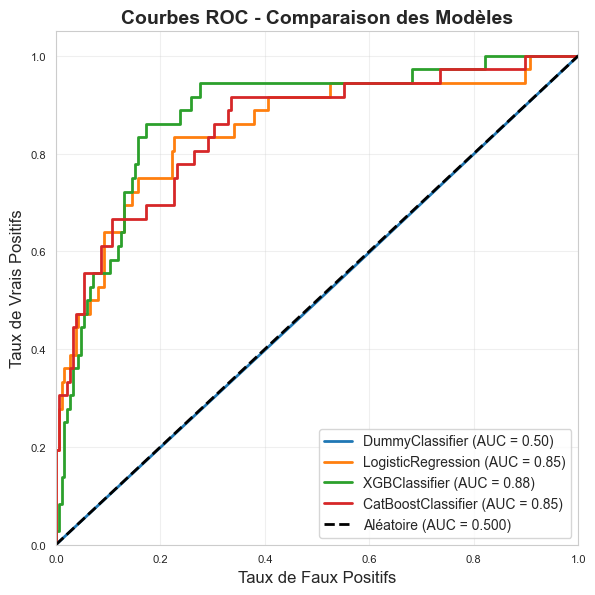

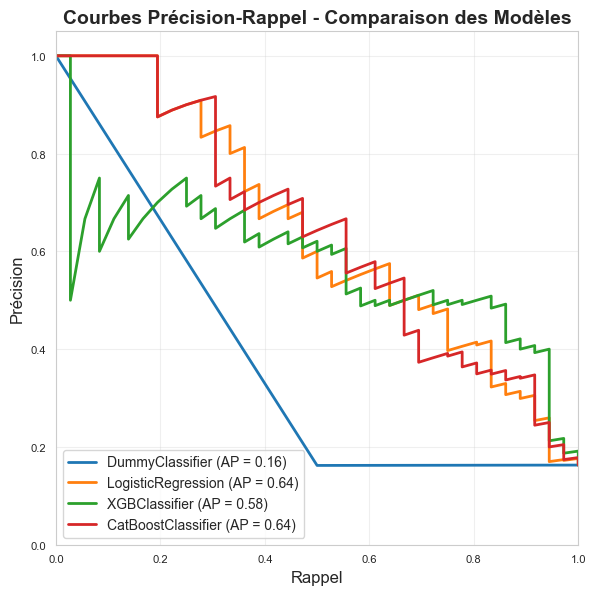

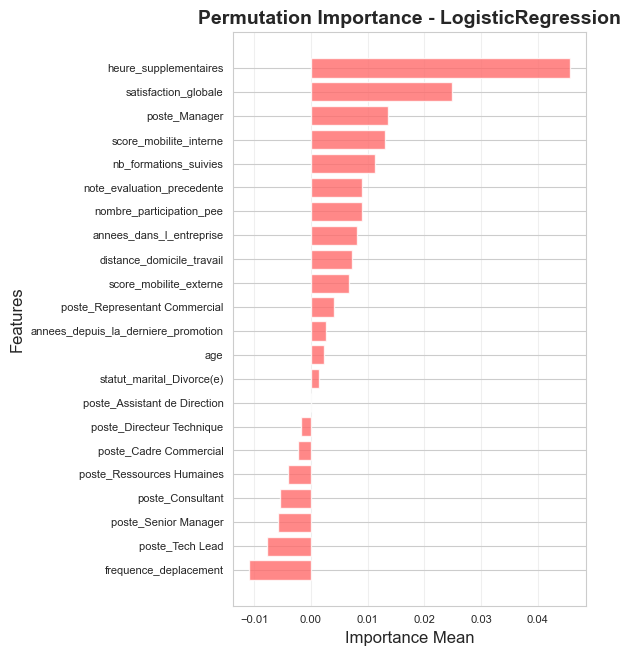

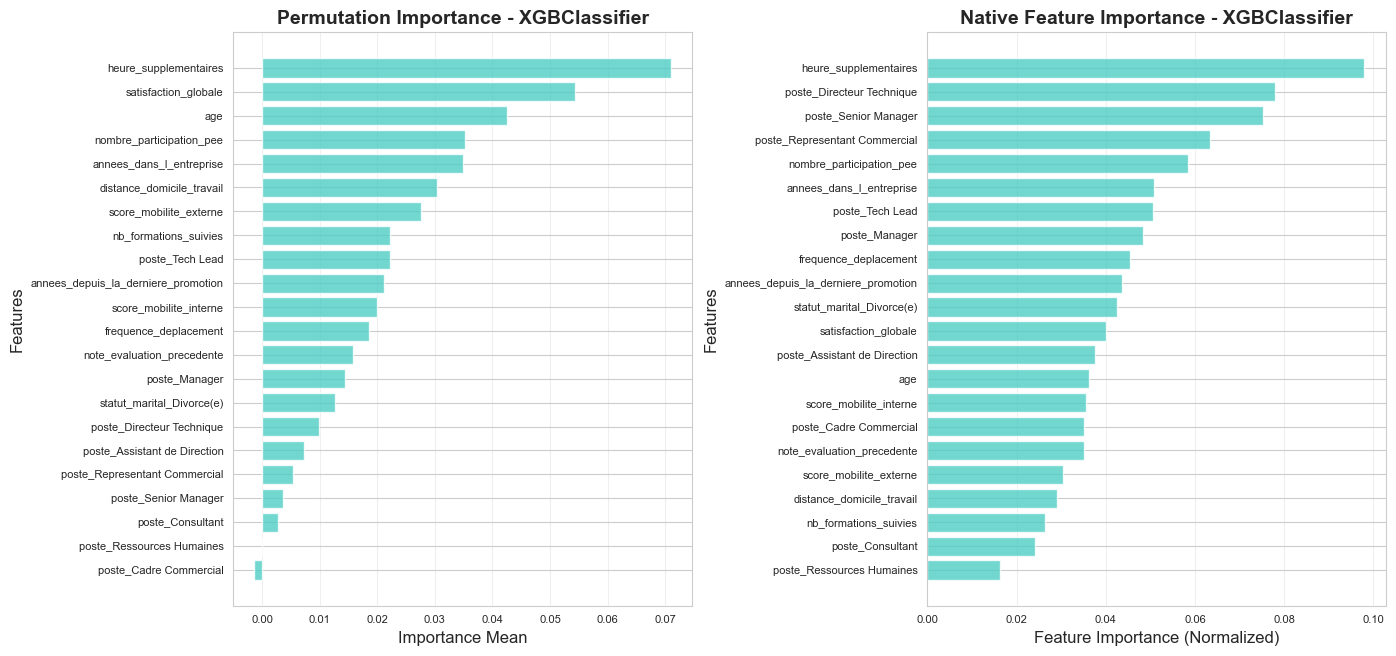

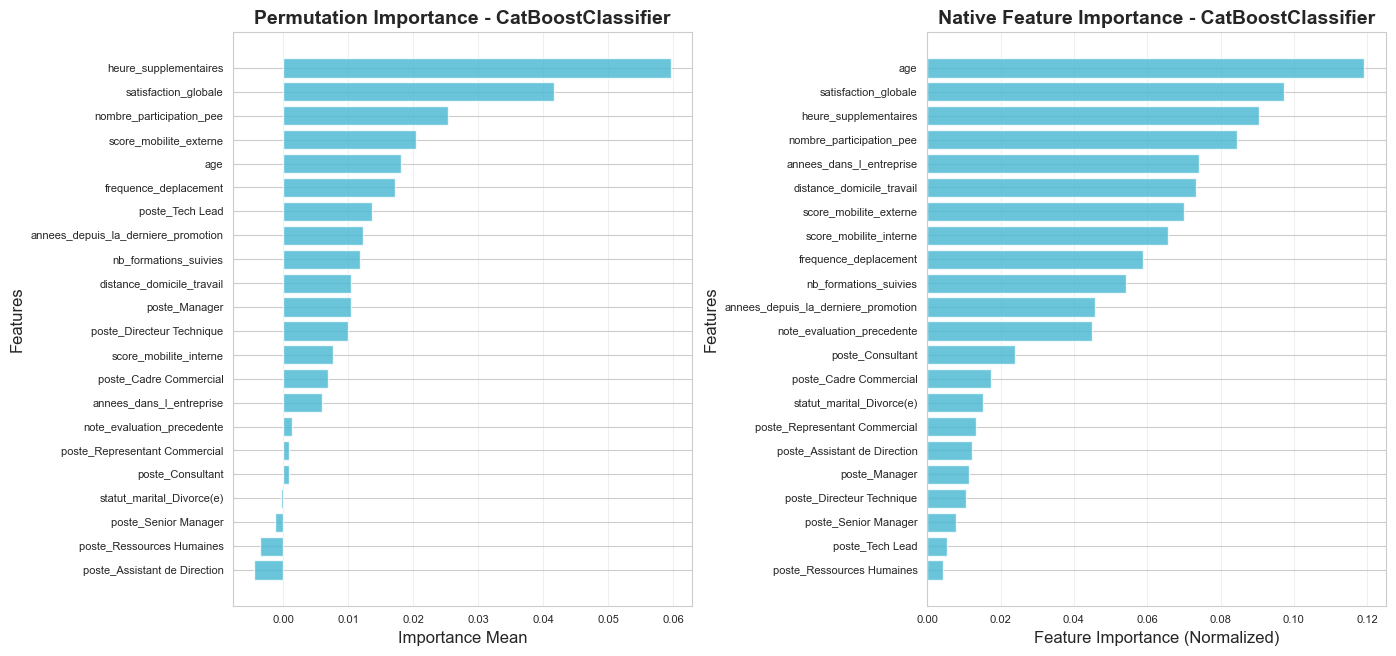

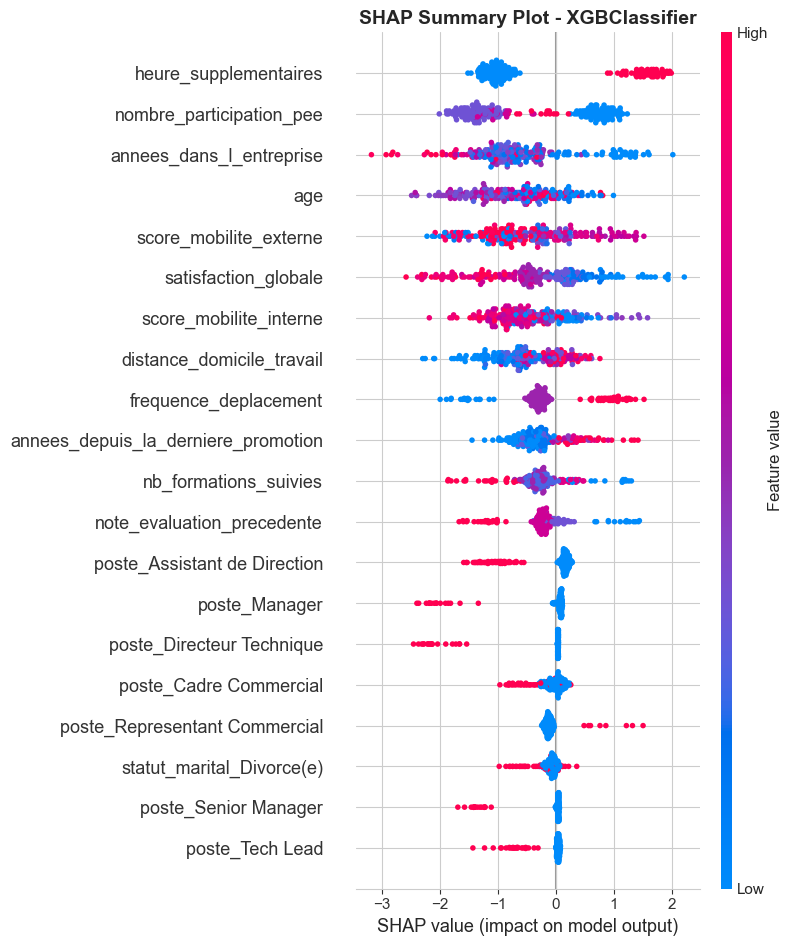

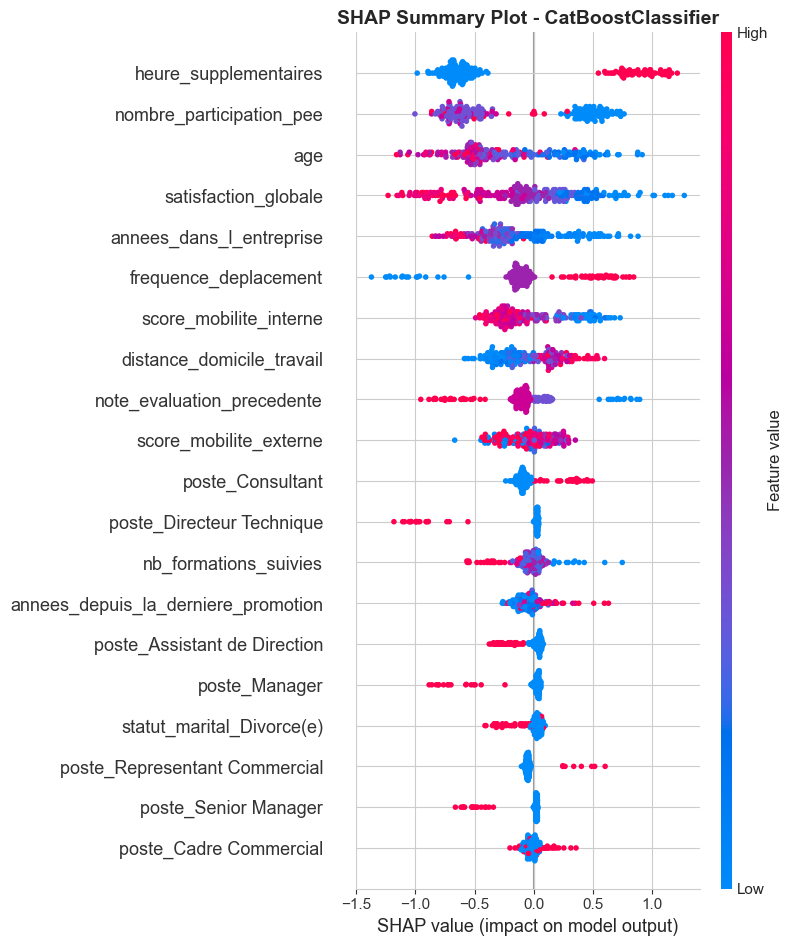

In [220]:
_plot_binary_roc_curves(all_curves)
_plot_binary_pr_curves(all_curves)
#_plot_permutation_importance(all_compute_perm_imp)
#_plot_native_feature_importance(all_compute_perm_imp)
_plot_feature_importance(all_compute_perm_imp)
_plot_shap(all_shap_metadata)

# Optimisation des Hypers-Parametres

In [221]:
def get_param_grids():
    """Définit les grilles de paramètres pour chaque modèle."""
    return {
        'DummyClassifier': {
            'strategy': ['most_frequent', 'stratified', 'uniform']
        },
        'LogisticRegression': {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'saga'],  # saga supporte l1 et l2
            'max_iter': [5000]  # Augmenter si nécessaire
        },
        'XGBClassifier': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 2, 5]
        },
        'CatBoostClassifier': {
            'iterations': [100, 200, 300],
            'depth': [4, 6, 8],
            'learning_rate': [0.01, 0.05, 0.1],
            'l2_leaf_reg': [1, 3, 5],
            'subsample': [0.8, 1.0]
        }
    }

def perform_grid_search(model, param_grid, X_train, y_train, cv=5, scoring='f1_macro'):
    """Effectue un GridSearchCV pour un modèle donné."""
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)
    return grid_search

def compare_models_gridsearch(X, y, test_size, cv=5, scoring='f1_macro'):
    """Compare tous les modèles avec GridSearchCV."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Standardisation pour la régression logistique
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grids = get_param_grids()

    base_models = {
        'DummyClassifier': (DummyClassifier(random_state=random_state), X_train, X_test),
        'LogisticRegression': (LogisticRegression(random_state=random_state, max_iter=5000), X_train_scaled, X_test_scaled),
        'XGBClassifier': (XGBClassifier(random_state=random_state, eval_metric='logloss'), X_train, X_test),
        'CatBoostClassifier': (CatBoostClassifier(random_state=random_state, verbose=False), X_train, X_test)
    }

    results = []
    print(f"\n{'='*70}")
    print(f"GridSearch en cours sur {len(base_models)} modèles...")
    print(f"{'='*70}\n")

    for i, (model_name, (base_model, X_tr, X_te)) in enumerate(base_models.items(), 1):
        print(f"[{i}/{len(base_models)}] {model_name}...", end=' ', flush=True)

        grid_search = perform_grid_search(
            base_model,
            param_grids[model_name],
            X_tr,
            y_train,
            cv=cv,
            scoring=scoring
        )

        best_model = grid_search.best_estimator_
        y_pred_test = best_model.predict(X_te)
        report_test = classification_report(y_test, y_pred_test, output_dict=True)

        result = {
            'model': model_name,
            'best_cv_score': round(grid_search.best_score_, 4),
            'test_accuracy': round(report_test['accuracy'], 4),
            'test_f1_macro': round(report_test['macro avg']['f1-score'], 4),
            'test_precision': round(report_test['macro avg']['precision'], 4),
            'test_recall': round(report_test['macro avg']['recall'], 4),
            'best_params': str(grid_search.best_params_)
        }
        results.append(result)

        print(f"✓ F1: {result['test_f1_macro']:.4f}")

    print(f"\n{'='*70}")
    print("Résultats finaux:")
    print(f"{'='*70}")

    df = pd.DataFrame(results)
    print(df[['model', 'best_cv_score', 'test_f1_macro', 'test_accuracy']].to_string(index=False))
    print(f"{'='*70}\n")

    return df

# Exécution
#results_df = compare_models_gridsearch(X, y,test_size=test_size,cv=5,scoring='f1_macro')

# Sauvegarde
#results_df.to_csv('exports/gridsearch_best_results.csv', index=False)